In [44]:
import torch 
import torch.nn as nn
from torch.utils.data import DataLoader, random_split

import torchvision
from torchvision import datasets
from torchvision.transforms import transforms

import pytorch_lightning as pl

In [4]:
from dotenv import load_dotenv
import os

DATASET_PATH = os.environ.get('DATASET_PATH',"./data")
BATCH_SIZE = 256 if torch.cuda.is_available() else 64
NUM_WORKERS = int(os.cpu_count() / 2)

In [6]:
class MnistDataLoader(pl.LightningDataModule):
    def __init__(self,root,batch_size,num_workers):
        super(MnistDataLoader,self).__init__()
        self.root = root
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307),(0.3081))
        ])
        
        
    def prepare_data(self):
        datasets.MNIST(root = self.root,train=True,download=True)
        datasets.MNIST(root = self.root,train=False,download=True)

    def setup(self, stage):
        if stage == "fit" or stage is None:
            train_dataset = datasets.MNIST(root = self.root,train=True,download=False,transform = self.transform)
            
            # Define the proportions for the split
            train_proportion = 0.8  # 80% for training
            val_proportion = 0.2  # 20% for validation
    
            # Calculate the sizes of training and validation sets based on the proportions
            train_size = int(train_proportion * len(train_dataset))
            val_size = len(train_dataset) - train_size
            
            # Use random_split to split the dataset
            self.train_dataset, self.val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])
        if stage == "test" or stage is None:
            self.test_dataset =  datasets.MNIST(root = self.root,train=False,download=False,transform = self.transform)
            

    def train_dataloader(self):
        return torch.utils.data.DataLoader(dataset=self.train_dataset,batch_size=self.batch_size,shuffle=True,num_workers=self.num_workers,pin_memory=True)
    
    def val_dataloader(self):
        return torch.utils.data.DataLoader(dataset=self.val_dataset,batch_size=self.batch_size,shuffle=False,num_workers=self.num_workers,pin_memory=True)
    
    def test_dataloader(self):
        return torch.utils.data.DataLoader(dataset=self.test_dataset,batch_size=self.batch_size,shuffle=False,num_workers=self.num_workers,pin_memory=True)
   

In [7]:
ds = MnistDataLoader(DATASET_PATH,BATCH_SIZE,NUM_WORKERS)

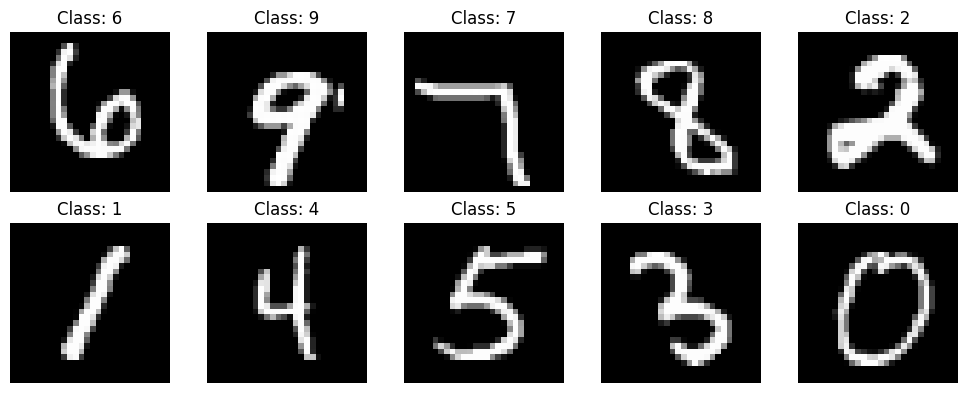

In [11]:
import matplotlib.pyplot as plt

# Sanity Check
ds.prepare_data()
ds.setup('fit')
dataloader = ds.train_dataloader()


# Create a dictionary to store one image per class
class_images = {}

# Iterate over the dataset and store one image per class
for image, label in ds.train_dataset:
    if label not in class_images:
        class_images[label] = image
        if len(class_images) == 10:  # Stop after storing one image per class
            break

# Display the images from each class
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, (label, image) in enumerate(class_images.items()):
    ax = axes[i // 5, i % 5]
    ax.imshow(image.squeeze(), cmap='gray')
    ax.set_title(f"Class: {label}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [32]:

class Generator(nn.Module):
    def __init__(self, latent_dim, img_shape):
        super(Generator, self).__init__()

        def _block(in_feature, out_feature, normalize=True):
            layers = [nn.Linear(in_feature, out_feature)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feature))
            layers.append(nn.LeakyReLU())
            return layers

        self.g_model = nn.Sequential(
            *_block(latent_dim, 128, normalize=False),
            *_block(128, 256),
            *_block(256, 512),
            *_block(512, 1024),
            nn.Linear(1024, img_shape),
            nn.Tanh()
        )

    def forward(self, x):
        return self.g_model(x)


In [43]:
class Discriminator(nn.Module):
    def __init__(self,in_feature):
        super(Discriminator, self).__init__()

        self.d_model = nn.Linear(nn.Linear(in_feature,1024),
                                nn.LeakyReLU(),
                                 nn.Linear(1024,512),
                                 nn.LeakyReLU(),
                                 nn.Linear(512,256),
                                 nn.LeakyReLU(),
                                 nn.Linear(256,128),
                                 nn.LeakyReLU(),
                                 nn.Linear(128,1),
                                 nn.Sigmoid())

    def forward(self,x):
        return self.d_model(x)

In [ ]:
class GAN(pl.LightningModule):
    def __init__(self,latent_dim,img_shape,lr,b1,b2):
        super().__init__()

        self.save_hyperparameters()

        self.generator = Generator(latent_dim,img_shape)
        self.discriminator = Discriminator(img_shape)

    def forward(self,z):
        return self.generator(z)

    def adversarial_loss(self,y_hat,y):
        return nn.functional.binary_cross_entropy(y_hat,y)

    def training_step(self,batch,batch_idx,optimizer_idx):
        imgs, _ = batch 

        # sample noise 
        z = torch.randn(imgs.shape[0],self.hparams.latent_dim)
        z = z.type_as(imgs)

        # ground truth 
        label_one = torch.ones(imgs.shape[0],1).type_as(imgs)
        label_zero = torch.zero(imgs.shape[0],1).type_as(imgs)

        # Train Generator
        if optimizer_idx == 0:

            self.generated_img = self(z)

            #log 
            sample_imgs = self.generated_img[:6]
            grid = torchvision.utils.make_grid(sample_imgs)
            self.logger.experiment.add_image('generated_images',grid,0)

            g_loss = self.adversarial_loss(self.discriminator(self.generated_img),label_one)
            self.log('g_loss',g_loss,prog_bar=True)
            return g_loss

        # Train discriminator
        if optimizer_idx == 1:
            # how well it can be label as real
            real_loss = self.adversarial_loss(self.discriminator(imgs),label_one)
            # how well it can be label as fake
            fake_loss = self.adversarial_loss(self.discriminator(self(z).detach()),label_zero)

            d_loss = (real_loss + fake_loss)/2
            self.log('d_loss',d_loss,prog_bar=True)
            return d_loss


    def configure_optimizers(self):
        g_opt = torch.optim.AdamW(self.generator.parameters(),lr=self.hparams.lr, betas=[self.hparams.b1,self.hparams.b2])
        d_opt = torch.optim.AdamW(self.discriminator.parameters(),lr=self.hparams.lr, betas=[self.hparams.b1,self.hparams.b2])            
            
        return [g_opt,d_opt], []
        



            
    